# 1. Import and setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, ttest_ind
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings('ignore')

In [106]:
# Setting up styling
sns.set(style="darkgrid")
sns.set_palette("flare")

print(sns.color_palette("flare").as_hex())
palette = sns.color_palette("flare").as_hex()
sns.color_palette("flare")

['#e98d6b', '#e3685c', '#d14a61', '#b13c6c', '#8f3371', '#6c2b6d']


[(0.9155979, 0.55210684, 0.42070204),
 (0.888292, 0.40830288, 0.36223756),
 (0.81942908, 0.28911553, 0.38102921),
 (0.69226314, 0.23413578, 0.42480327),
 (0.56041794, 0.19845221, 0.44207535),
 (0.42355299, 0.16934709, 0.42581586)]

In [107]:
RANDOM_STATE=42

In [108]:
# Helper function

"""
Plots histogram and boxplot to compare difference in distribution of given label
- label: the feature to be compared
- title: title of the figure
"""
def plot_mean_difference(df, label, title, colours, features_kde):
    fig, axes = plt.subplots(2, len(features_kde), figsize=(30, 7))
    value = df[label].unique()
    p_vals = []

    for i in range(len(features_kde)):
        feature = features_kde[i]
        for j, val in enumerate(df[label].unique()):
            sns.kdeplot(df[df[label] == val][feature], ax=axes[0, i], fill=True, label=val, color=colours[j])
        axes[0, i].set(ylabel=None)
        axes[0, i].set(xlabel=None)
        axes[0, i].set_title(feature)

        sns.boxplot(ax=axes[1, i], x=label, y=feature, data=df, palette=colours)
        axes[1, i].set(ylabel=None)
        axes[1, i].set(xlabel=None)
        
        t_statistic, p_value = ttest_ind(df[df[label] == value[0]][feature].dropna(),
                                 df[df[label] == value[1]][feature].dropna())
        p_vals.append(p_value)
    axes[0,-1].legend(title=label)

    fig.suptitle(title)
    plt.show()
    return dict(zip(features_kde, p_vals))

"""
Plot coefficient correlation inside a pair plot, used in pair_plot function
"""
def reg_coef(x,y,label=None,color=None,hue=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    marker_size = abs(r) * 10000
    ax.scatter([.5], [.5], marker_size, [r], alpha=0.6, cmap="flare",
            vmin=-1, vmax=1, transform=ax.transAxes)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

"""
Plot pair grid of bivariate analysis, includes scatter plot and correlation computation
- df: dataframe containing all features
- label: the feature to be compared
- title: title of figure
"""
def pair_plot(df, label, title, colours):
    g = sns.PairGrid(df, hue=label, diag_sharey=False, palette=colours)
    g.map_upper(reg_coef, hue=None)
    g.map_diag(sns.kdeplot, fill=True)
    g.map_lower(sns.scatterplot)

    g.add_legend(adjust_subtitles=True, title=label)
    g.fig.subplots_adjust(top=0.95)
    g.fig.suptitle(title)

    plt.show()

# 2. Read dataset

In [109]:
df = pd.read_csv('../dataset/icd_final_27th_Oct.csv', index_col=0)
df.head()

,hadm_id,alcoholism,gender,anchor_age,deathtime,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,...,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
0,23260768,0,F,60,NaN,21.9,24.0,1.2,142.0,75.0,...,10.7,121.0,411.0,14.0,10.0,0.6,14.0,120.0,50.0,60.5
1,23059383,0,F,72,2147-11-06T18:30:00,34.3,29.0,1.3,55.0,32.0,...,14.3,242.0,116.0,18.2,740.0,2.2,18.0,130.0,50.0,65.0
2,20779074,0,F,88,NaN,33.6,18.0,1.1,130.0,62.0,...,12.1,93.0,224.0,16.4,17.0,0.5,14.0,130.0,50.0,59.7
3,20772091,0,M,34,2179-02-25T16:08:00,30.7,13.0,0.5,112.0,66.0,...,6.7,148.0,372.0,11.2,26.0,0.1,10.0,150.0,50.0,64.0
4,21453368,0,F,38,2133-04-05T10:20:00,25.7,24.0,0.9,176.0,106.0,...,0.1,84.0,41.0,18.9,32.0,1.2,16.0,120.0,60.0,92.0


In [110]:
# Label mortality
df['mortality'] = df['deathtime'].apply(lambda x: 'Survive' if x is np.nan else 'Dead')
df['mortality'].value_counts()

mortality
Survive    373
Dead        81
Name: count, dtype: int64

In [111]:
df.columns

Index(['hadm_id', 'alcoholism', 'gender', 'anchor_age', 'deathtime',
       'hematocrit_serum', 'blood_urea_nitrogen', 'serum_creatinine',
       'Non_Invasive_Blood_Pressure_systolic',
       'Non_Invasive_Blood_Pressure_diastolic', 'lipase', 'white_bloodcells',
       'Glucose_serum', 'platelet_PLT', 'Prothrombin_time',
       'aminotransferase_ALT', 'Total_Bilirubin', 'Anion_gap',
       'Heart_rate_Alarm_High', 'Heart_rate_Alarm_low', 'earliest_weight_kg',
       'mortality'],
      dtype='object')

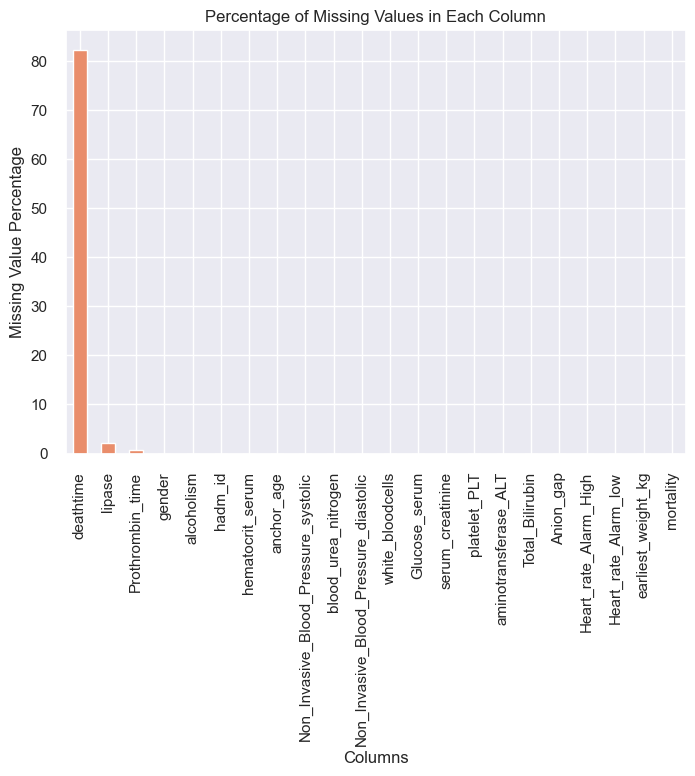

In [112]:
# Datatype and missing value information
missing_percentage = (df.isnull().sum() / df.shape[0]) * 100
    
missing_percentage.sort_values(ascending=False).plot(kind='bar', color=palette[0])
plt.xlabel('Columns')
plt.ylabel('Missing Value Percentage')
plt.title('Percentage of Missing Values in Each Column')
plt.show()

In [113]:
missing_columns = missing_percentage.sort_values(ascending=False)[:1]
missing_columns

deathtime    82.15859
dtype: float64

In [114]:
df_clean = df.drop(missing_columns.index, axis=1)
df_clean.head()

,hadm_id,alcoholism,gender,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,...,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,mortality
0,23260768,0,F,60,21.9,24.0,1.2,142.0,75.0,171.0,...,121.0,411.0,14.0,10.0,0.6,14.0,120.0,50.0,60.5,Survive
1,23059383,0,F,72,34.3,29.0,1.3,55.0,32.0,10.0,...,242.0,116.0,18.2,740.0,2.2,18.0,130.0,50.0,65.0,Dead
2,20779074,0,F,88,33.6,18.0,1.1,130.0,62.0,353.0,...,93.0,224.0,16.4,17.0,0.5,14.0,130.0,50.0,59.7,Survive
3,20772091,0,M,34,30.7,13.0,0.5,112.0,66.0,NaN,...,148.0,372.0,11.2,26.0,0.1,10.0,150.0,50.0,64.0,Dead
4,21453368,0,F,38,25.7,24.0,0.9,176.0,106.0,113.0,...,84.0,41.0,18.9,32.0,1.2,16.0,120.0,60.0,92.0,Dead


In [115]:
(df_clean.isnull().sum(axis=1) / df_clean.shape[1]).value_counts().sort_index()

0.000000    441
0.047619     13
Name: count, dtype: int64

In [116]:
# Statistical description of numerical features
df_clean.describe(include=[np.number]).round(2)

,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
count,454.00,454.00,454.00,454.00,454.00,454.00,454.00,454.00,444.00,454.00,454.00,454.00,451.00,454.0,454.00,454.00,454.00,454.00,454.00
mean,24933999.80,0.22,58.60,33.83,29.54,1.66,128.64,73.23,603.17,13.88,159.63,227.47,17.16,226.8,2.77,16.19,124.06,54.46,84.62
std,2897739.39,0.41,17.23,7.17,25.10,1.71,26.53,19.98,945.91,8.83,126.40,140.31,9.44,798.9,5.23,5.57,10.69,8.10,23.20
min,20009550.00,0.00,22.00,16.00,3.00,0.10,55.00,12.00,5.00,0.10,35.00,10.00,8.80,2.0,0.10,5.00,50.00,20.00,32.00
25%,22386114.50,0.00,46.25,28.70,13.00,0.70,110.00,59.00,57.75,8.40,102.00,129.25,13.00,24.0,0.50,13.00,120.00,50.00,68.75
50%,25102125.00,0.00,57.50,33.00,22.00,1.10,127.00,71.50,210.00,12.05,126.00,199.50,14.40,51.0,1.00,15.00,120.00,50.00,80.50
75%,27559023.00,0.00,72.00,38.38,37.00,1.80,146.00,84.00,772.25,17.85,178.00,286.75,17.05,150.0,2.80,18.00,130.00,60.00,98.20
max,29966638.00,1.00,91.00,56.50,173.00,14.40,222.00,134.00,6095.00,77.80,1638.00,942.00,93.20,9582.0,46.50,49.00,180.00,135.00,168.20


In [117]:
# Statistical description of categorical features
df_clean.describe(include=[np.object_])

,gender,mortality
count,454,454
unique,2,2
top,M,Survive
freq,266,373


In [118]:
# Number of distinct patients
print('Number of distinct patients: ', df_clean.hadm_id.unique().shape[0])
print('Number of duplication', len(df_clean[df_clean.duplicated()]))

Number of distinct patients:  454
Number of duplication 0


In [119]:
df_clean.columns

Index(['hadm_id', 'alcoholism', 'gender', 'anchor_age', 'hematocrit_serum',
       'blood_urea_nitrogen', 'serum_creatinine',
       'Non_Invasive_Blood_Pressure_systolic',
       'Non_Invasive_Blood_Pressure_diastolic', 'lipase', 'white_bloodcells',
       'Glucose_serum', 'platelet_PLT', 'Prothrombin_time',
       'aminotransferase_ALT', 'Total_Bilirubin', 'Anion_gap',
       'Heart_rate_Alarm_High', 'Heart_rate_Alarm_low', 'earliest_weight_kg',
       'mortality'],
      dtype='object')

In [120]:
features_kde = ['hematocrit_serum',
       'blood_urea_nitrogen', 'serum_creatinine',
       'Non_Invasive_Blood_Pressure_systolic',
       'Non_Invasive_Blood_Pressure_diastolic', 'white_bloodcells',
       'Glucose_serum', 'platelet_PLT', 'Anion_gap', 'Heart_rate_Alarm_High',
       'Heart_rate_Alarm_low', 'earliest_weight_kg']

# 4. Preprocessing

In [121]:
# Drop gender
X = df_clean.drop(['hadm_id', 'gender', 'mortality'], axis=1)
X.head()

,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
0,0,60,21.9,24.0,1.2,142.0,75.0,171.0,10.7,121.0,411.0,14.0,10.0,0.6,14.0,120.0,50.0,60.5
1,0,72,34.3,29.0,1.3,55.0,32.0,10.0,14.3,242.0,116.0,18.2,740.0,2.2,18.0,130.0,50.0,65.0
2,0,88,33.6,18.0,1.1,130.0,62.0,353.0,12.1,93.0,224.0,16.4,17.0,0.5,14.0,130.0,50.0,59.7
3,0,34,30.7,13.0,0.5,112.0,66.0,NaN,6.7,148.0,372.0,11.2,26.0,0.1,10.0,150.0,50.0,64.0
4,0,38,25.7,24.0,0.9,176.0,106.0,113.0,0.1,84.0,41.0,18.9,32.0,1.2,16.0,120.0,60.0,92.0


In [122]:
X['gender'] = LabelEncoder().fit_transform(df_clean['gender'])
X['mortality'] = LabelEncoder().fit_transform(df_clean['mortality'])
X.head()

,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,gender,mortality
0,0,60,21.9,24.0,1.2,142.0,75.0,171.0,10.7,121.0,411.0,14.0,10.0,0.6,14.0,120.0,50.0,60.5,0,1
1,0,72,34.3,29.0,1.3,55.0,32.0,10.0,14.3,242.0,116.0,18.2,740.0,2.2,18.0,130.0,50.0,65.0,0,0
2,0,88,33.6,18.0,1.1,130.0,62.0,353.0,12.1,93.0,224.0,16.4,17.0,0.5,14.0,130.0,50.0,59.7,0,1
3,0,34,30.7,13.0,0.5,112.0,66.0,NaN,6.7,148.0,372.0,11.2,26.0,0.1,10.0,150.0,50.0,64.0,1,0
4,0,38,25.7,24.0,0.9,176.0,106.0,113.0,0.1,84.0,41.0,18.9,32.0,1.2,16.0,120.0,60.0,92.0,0,0


In [123]:
X = X.fillna(X.median())

In [124]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.5280845 ,  0.08150007, -1.66555332, ..., -1.04050685,
        -1.18949301,  0.46600234],
       [-0.5280845 ,  0.77853677,  0.06498431, ..., -0.84635974,
        -1.18949301, -2.14591199],
       [-0.5280845 ,  1.70791903, -0.03270733, ..., -1.07502189,
        -1.18949301,  0.46600234],
       ...,
       [-0.5280845 ,  0.48810481, -0.11644302, ...,  0.43932554,
         0.84069431,  0.46600234],
       [-0.5280845 ,  0.83662316, -0.70259287, ..., -0.77301528,
         0.84069431,  0.46600234],
       [-0.5280845 ,  1.01088233,  0.05102836, ..., -0.54435313,
         0.84069431,  0.46600234]])

One of the feature of standard scaling is that, we can detect outliers by filtering values `abs(x) > 3.5`. We choose number `3.5` as it does not discard huge amount of data while still being reasonable number for an outlier.

In [125]:
# Outliers detection for each features
X_cleaned = pd.DataFrame(X_scaled)
X_cleaned = X_scaled[(np.abs(X_scaled) < 3.5).all(axis=1)]
df_clean = df_clean[(np.abs(X_scaled) < 3.5).all(axis=1)].reset_index(drop=True)
print("Number of cleaned record is", len(X_cleaned))
X_cleaned

Number of cleaned record is 394


array([[-0.5280845 ,  0.08150007, -1.66555332, ..., -1.04050685,
        -1.18949301,  0.46600234],
       [-0.5280845 ,  0.77853677,  0.06498431, ..., -0.84635974,
        -1.18949301, -2.14591199],
       [-0.5280845 ,  1.70791903, -0.03270733, ..., -1.07502189,
        -1.18949301,  0.46600234],
       ...,
       [-0.5280845 , -0.8478822 ,  0.06498431, ...,  0.32715165,
         0.84069431,  0.46600234],
       [-0.5280845 ,  0.48810481, -0.11644302, ...,  0.43932554,
         0.84069431,  0.46600234],
       [-0.5280845 ,  1.01088233,  0.05102836, ..., -0.54435313,
         0.84069431,  0.46600234]])

# 5. K-Means


## 5.1. Finding optimal cluster

#### Manual

In [126]:
wcss = []
ss = []

# Run algorithm through different number of clusters
for i in range(2, 15):
    kmeans = KMeans(n_clusters=i, random_state=RANDOM_STATE)
    kmeans.fit(X_cleaned)

    # Record within cluster sum of squares
    wcss.append(kmeans.inertia_)

    # Record silhouette score
    sil_score = silhouette_score(X_cleaned, kmeans.labels_)
    ss.append(sil_score)

In [127]:
total_var = np.sum(np.var(X, axis=0)) * X.shape[0]
total_var

704540688.2927753

In [128]:
var_explained = (1 - (np.array(wcss) / np.sum(wcss))) * 100
var_explained

array([90.13950734, 90.81652424, 91.37246408, 91.76374269, 92.14272506,
       92.41615296, 92.6535884 , 92.77398495, 92.90188771, 93.07675526,
       93.22159276, 93.3378334 , 93.38324115])

Text(0.5, 1.0, 'Total Variance Explained')

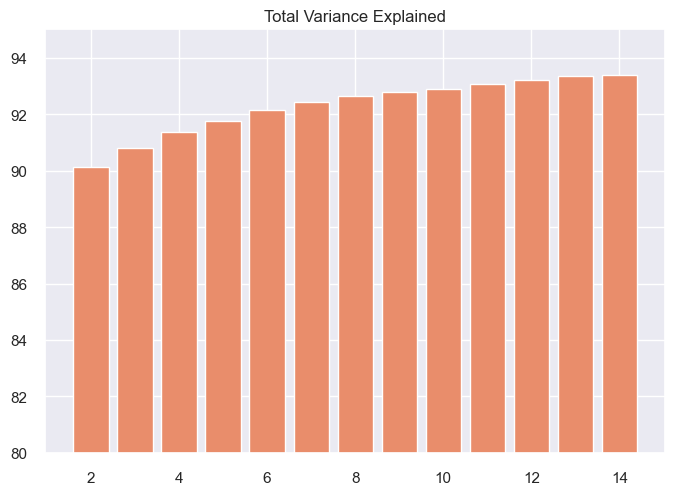

In [129]:
plt.bar(range(2,15), var_explained)
plt.ylim((80,95))
plt.title("Total Variance Explained")

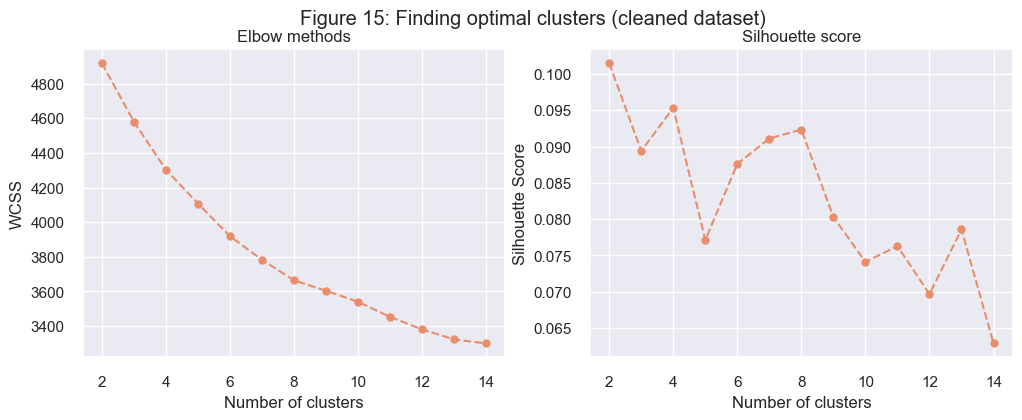

In [130]:
# Plot Elbow graph
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(2, 15), wcss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow methods')

# Plot Silhouette Score graph
plt.subplot(1, 2, 2)
plt.plot(range(2, 15), ss, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette score')

plt.suptitle("Figure 15: Finding optimal clusters (cleaned dataset)")
plt.show()

#### On Yellowbrick

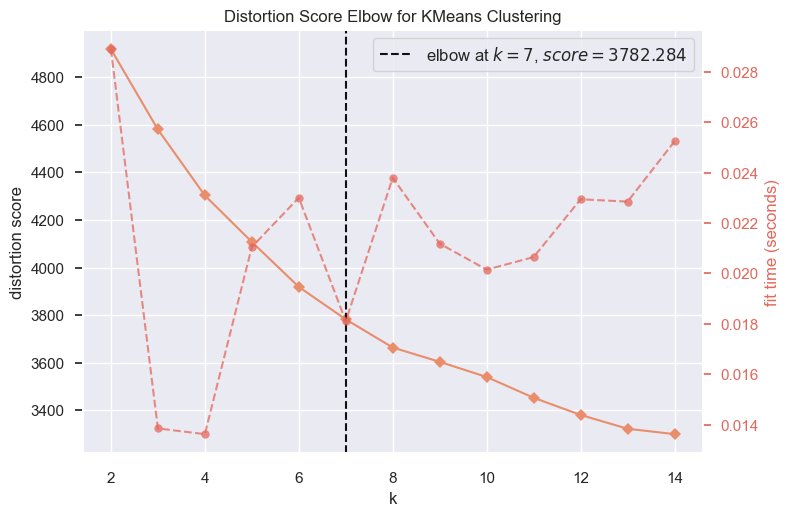

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [132]:
model = KMeans(random_state=RANDOM_STATE)
visualizer = KElbowVisualizer(model, k=(2,15))
# Fit and show the performance with dataset
visualizer.fit(X_cleaned)
visualizer.show()

In [134]:
optimal_cluster = 4

## 5.2. Fitting the model

In [135]:
# Fit model
kmeans = KMeans(n_clusters=optimal_cluster, random_state=RANDOM_STATE)
kmeans.fit(X_cleaned)

df_clean['cluster'] = kmeans.labels_.astype(object)
df_clean.head()

,hadm_id,alcoholism,gender,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,...,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg,mortality,cluster
0,23260768,0,F,60,21.9,24.0,1.2,142.0,75.0,171.0,...,411.0,14.0,10.0,0.6,14.0,120.0,50.0,60.5,Survive,1
1,23059383,0,F,72,34.3,29.0,1.3,55.0,32.0,10.0,...,116.0,18.2,740.0,2.2,18.0,130.0,50.0,65.0,Dead,0
2,20779074,0,F,88,33.6,18.0,1.1,130.0,62.0,353.0,...,224.0,16.4,17.0,0.5,14.0,130.0,50.0,59.7,Survive,1
3,20772091,0,M,34,30.7,13.0,0.5,112.0,66.0,NaN,...,372.0,11.2,26.0,0.1,10.0,150.0,50.0,64.0,Dead,1
4,21453368,0,F,38,25.7,24.0,0.9,176.0,106.0,113.0,...,41.0,18.9,32.0,1.2,16.0,120.0,60.0,92.0,Dead,2


In [136]:
# Evaluation metric
wcss = kmeans.inertia_
ss = silhouette_score(X_cleaned, kmeans.labels_)

print(f"Fitting model with {optimal_cluster} clusters, resulting on {round(wcss,2)} WCSS and {round(ss,2)} silhouette score")

Fitting model with 4 clusters, resulting on 4302.8 WCSS and 0.1 silhouette score


In [137]:
# Center of clusters
kmeans_center = scaler.inverse_transform(kmeans.cluster_centers_)
pd.DataFrame(dict(zip(df_clean.columns, kmeans_center.T)))

,hadm_id,alcoholism,gender,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
0,9.230769e-02,70.415385,33.944615,55.246154,3.012308,115.815385,60.046154,631.000000,12.916923,160.200000,174.430769,17.129231,217.892308,2.969231,19.630769,122.846154,52.923077,78.941538,0.538462,0.353846
1,-1.665335e-16,63.432836,30.800000,21.134328,1.044030,117.552239,64.373134,390.649254,12.983582,124.843284,247.179104,15.898507,137.858209,1.802239,13.582090,123.246269,53.208955,76.036567,0.305970,0.962687
2,-1.387779e-16,54.762712,37.383898,23.008475,1.261017,145.203390,85.449153,541.415254,14.759322,162.169492,231.245763,16.222881,130.991525,1.993220,15.559322,124.872881,54.364407,97.221186,0.830508,0.923729
3,1.000000e+00,47.311688,34.490909,17.350649,1.040260,133.532468,83.259740,460.506494,12.075325,155.779221,224.246753,14.283117,166.532468,2.510390,15.220779,124.155844,54.805195,83.680519,0.714286,0.935065


## 5.3. Visualization

### Clusters Visualization

In [138]:
df_clean.cluster.value_counts()

cluster
1    134
2    118
3     77
0     65
Name: count, dtype: int64

In [139]:
def stat_cum(cluster):
    cluster0 = df_clean[df_clean.cluster == cluster]
    print(f"Percentage of women and men (respectively) {round(100 * sum(cluster0.gender == 'F') / len(cluster0),2)} and {round(100 * sum(cluster0.gender == 'M') / len(cluster0),2)}")
    print(f"Mortality rate is {round(100* len(cluster0[cluster0.mortality == 'Dead']) / len(cluster0),2)}")
    display(round(cluster0.describe(),2))

In [141]:
for i in range(4):
    print("====================== Cluster %s =========================" % (i))
    stat_cum(i)

====================== Cluster 0 =========================
Percentage of women and men (respectively) 46.15 and 53.85
Mortality rate is 64.62


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
count,65.00,65.00,65.00,65.00,65.00,65.00,65.00,65.00,61.00,65.00,65.00,65.00,64.00,65.00,65.00,65.00,65.00,65.00,65.00
mean,25133958.17,0.09,70.42,33.94,55.25,3.01,115.82,60.05,658.61,12.92,160.20,174.43,17.17,217.89,2.97,19.63,122.85,52.92,78.94
std,2976502.06,0.29,14.93,7.65,25.06,1.82,26.47,13.51,775.02,8.47,90.65,105.09,5.75,462.93,4.12,5.93,5.73,5.44,18.39
min,20009550.00,0.00,31.00,21.50,13.00,0.60,55.00,32.00,8.00,0.70,46.00,17.00,11.10,6.00,0.10,11.00,120.00,30.00,45.00
25%,22381259.00,0.00,61.00,28.50,39.00,1.50,99.00,49.00,83.00,6.80,103.00,103.00,13.78,25.00,0.50,15.00,120.00,50.00,67.00
50%,25547716.00,0.00,75.00,32.60,52.00,2.50,113.00,61.00,252.00,10.90,139.00,157.00,15.10,49.00,1.20,18.00,120.00,50.00,78.60
75%,27801141.00,0.00,82.00,40.50,70.00,4.40,137.00,68.00,1200.00,16.50,177.00,229.00,18.12,186.00,3.60,23.00,120.00,60.00,87.00
max,29966638.00,1.00,91.00,51.30,110.00,7.60,169.00,100.00,3187.00,42.80,532.00,400.00,38.40,2976.00,17.80,35.00,140.00,60.00,124.00


====================== Cluster 1 =========================
Percentage of women and men (respectively) 69.4 and 30.6
Mortality rate is 3.73


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
count,134.00,134.0,134.00,134.00,134.00,134.00,134.00,134.00,133.00,134.00,134.00,134.00,133.00,134.00,134.00,134.00,134.00,134.00,134.00
mean,24728695.99,0.0,63.43,30.80,21.13,1.04,117.55,64.37,392.01,12.98,124.84,247.18,15.91,137.86,1.80,13.58,123.25,53.21,76.04
std,2962298.41,0.0,17.82,5.28,13.17,0.64,19.57,13.97,587.06,7.13,58.74,126.30,5.92,238.07,1.86,3.46,9.12,4.65,17.91
min,20079585.00,0.0,22.00,17.70,3.00,0.20,76.00,12.00,5.00,0.40,46.00,10.00,9.40,2.00,0.10,5.00,100.00,50.00,32.00
25%,22281757.00,0.0,52.25,27.22,11.25,0.60,103.00,55.25,43.00,7.98,97.00,162.00,13.10,24.25,0.52,12.00,120.00,50.00,63.42
50%,24630964.50,0.0,63.50,30.65,18.00,0.90,115.00,65.00,149.00,11.75,113.00,224.00,14.20,54.50,1.00,13.00,120.00,50.00,74.25
75%,27525647.50,0.0,77.50,34.58,26.00,1.30,130.75,73.00,522.00,17.18,137.00,319.75,15.90,150.00,2.40,15.00,120.00,60.00,86.75
max,29903947.00,0.0,91.00,42.20,81.00,3.40,184.00,97.00,3516.00,32.10,560.00,653.00,45.30,1896.00,8.30,30.00,160.00,60.00,129.20


====================== Cluster 2 =========================
Percentage of women and men (respectively) 16.95 and 83.05
Mortality rate is 7.63


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
count,118.00,118.0,118.00,118.00,118.00,118.00,118.00,118.00,116.00,118.00,118.00,118.00,118.00,118.00,118.00,118.00,118.00,118.00,118.00
mean,24673603.92,0.0,54.76,37.38,23.01,1.26,145.20,85.45,547.13,14.76,162.17,231.25,16.22,130.99,1.99,15.56,124.87,54.36,97.22
std,2917851.74,0.0,16.02,7.28,15.07,0.89,24.22,18.34,762.52,7.65,69.50,127.84,6.20,264.53,2.50,3.17,10.07,5.21,25.15
min,20024364.00,0.0,25.00,23.20,6.00,0.10,90.00,44.00,6.00,0.10,69.00,17.00,10.00,4.00,0.10,9.00,100.00,45.00,48.20
25%,22192257.25,0.0,44.00,32.12,12.00,0.70,130.50,73.25,56.50,9.20,111.50,157.25,13.30,26.00,0.60,14.00,120.00,50.00,78.82
50%,24693957.50,0.0,54.00,36.65,18.00,1.00,144.50,83.50,184.50,13.80,149.00,203.50,14.60,52.00,0.90,15.00,120.00,50.00,94.50
75%,27111944.50,0.0,66.75,43.08,28.75,1.40,158.00,98.00,753.25,19.30,196.75,283.75,16.58,146.25,2.18,17.00,130.00,60.00,111.82
max,29956550.00,0.0,87.00,56.50,82.00,5.40,207.00,133.00,3705.00,41.50,396.00,687.00,47.80,2060.00,12.40,25.00,160.00,70.00,165.60


====================== Cluster 3 =========================
Percentage of women and men (respectively) 28.57 and 71.43
Mortality rate is 6.49


,hadm_id,alcoholism,anchor_age,hematocrit_serum,blood_urea_nitrogen,serum_creatinine,Non_Invasive_Blood_Pressure_systolic,Non_Invasive_Blood_Pressure_diastolic,lipase,white_bloodcells,Glucose_serum,platelet_PLT,Prothrombin_time,aminotransferase_ALT,Total_Bilirubin,Anion_gap,Heart_rate_Alarm_High,Heart_rate_Alarm_low,earliest_weight_kg
count,77.00,77.0,77.00,77.00,77.00,77.00,77.00,77.00,77.00,77.00,77.00,77.00,76.00,77.00,77.00,77.00,77.00,77.00,77.00
mean,25438015.38,1.0,47.31,34.49,17.35,1.04,133.53,83.26,460.51,12.08,155.78,224.25,14.28,166.53,2.51,15.22,124.16,54.81,83.68
std,2834562.64,0.0,10.54,7.03,11.88,0.73,24.45,19.42,628.89,6.11,81.13,156.57,3.74,370.23,3.49,5.06,7.50,5.28,20.49
min,20561449.00,1.0,25.00,20.70,3.00,0.20,73.00,39.00,13.00,2.50,66.00,28.00,8.80,9.00,0.20,5.00,120.00,40.00,45.40
25%,23254292.00,1.0,40.00,29.50,8.00,0.60,115.00,69.00,73.00,7.50,105.00,109.00,12.38,22.00,0.60,12.00,120.00,50.00,69.00
50%,25338284.00,1.0,47.00,33.50,14.00,0.80,132.00,80.00,207.00,10.90,128.00,182.00,13.25,38.00,1.30,14.00,120.00,50.00,80.00
75%,27998706.00,1.0,55.00,39.50,25.00,1.20,151.00,96.00,492.00,15.80,186.00,282.00,15.02,113.00,3.00,17.00,130.00,60.00,98.20
max,29961750.00,1.0,68.00,54.30,67.00,4.10,189.00,134.00,2808.00,33.90,571.00,690.00,34.20,2095.00,17.90,34.00,150.00,60.00,150.00


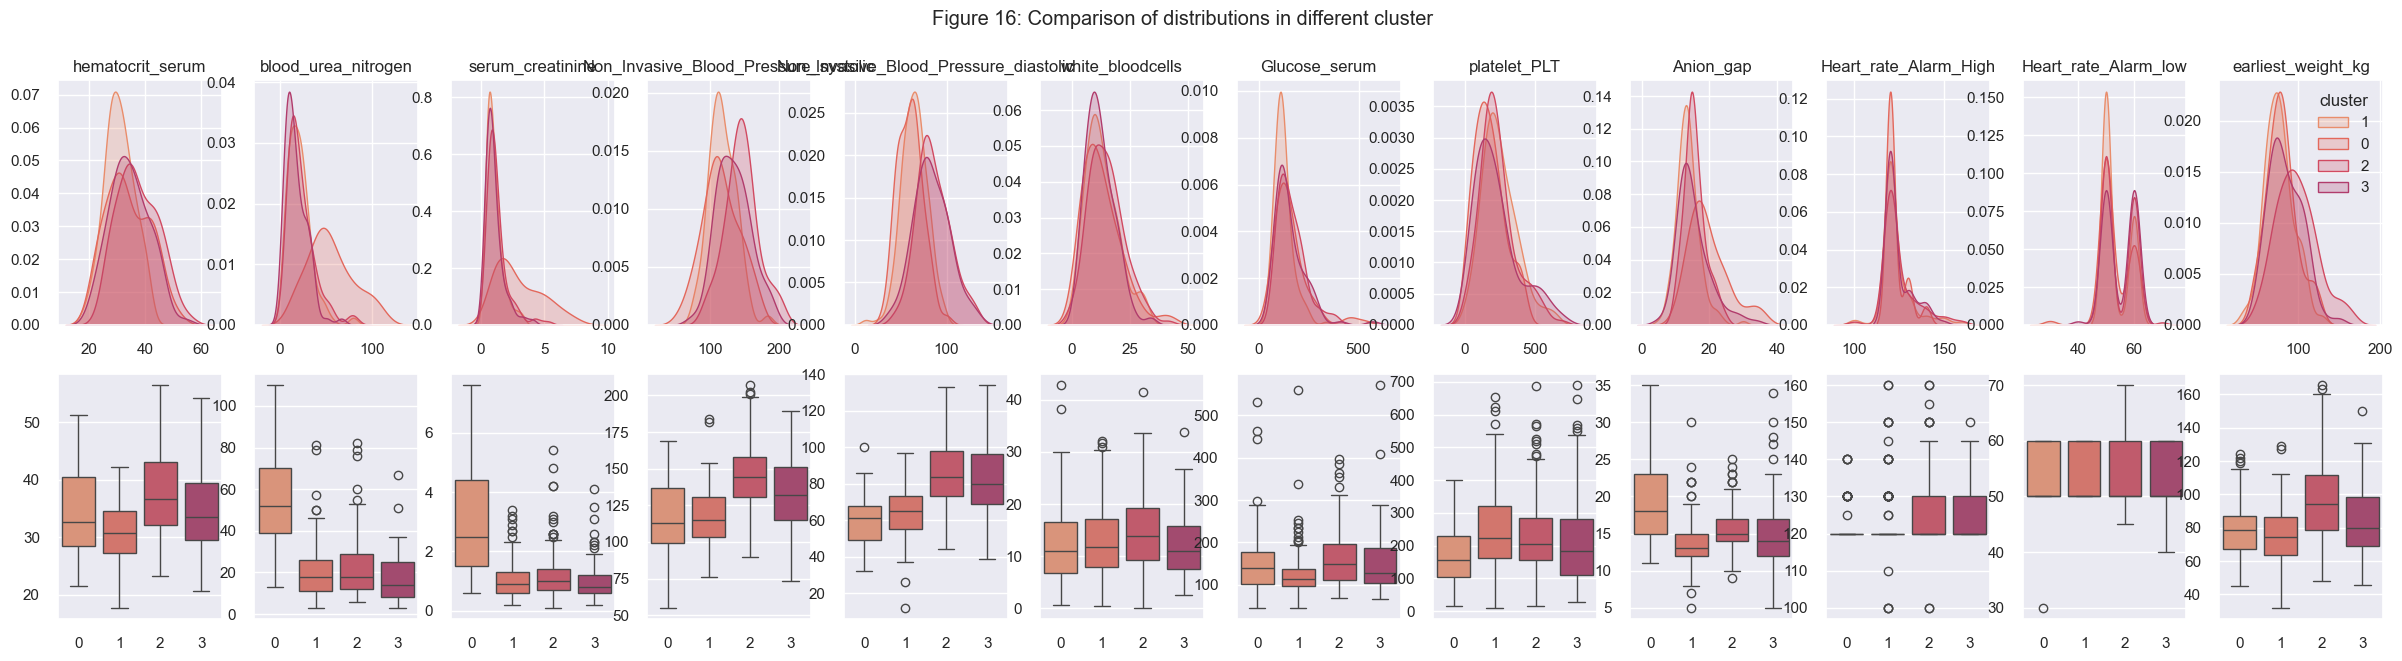

{'hematocrit_serum': 0.0008667057507688637,
 'blood_urea_nitrogen': 4.5675679021424216e-27,
 'serum_creatinine': 7.032522919176111e-23,
 'Non_Invasive_Blood_Pressure_systolic': 0.6028442920216336,
 'Non_Invasive_Blood_Pressure_diastolic': 0.03964896930795013,
 'white_bloodcells': 0.9537080423060312,
 'Glucose_serum': 0.0011154034996744186,
 'platelet_PLT': 8.391871428640711e-05,
 'Anion_gap': 1.3079181587331418e-16,
 'Heart_rate_Alarm_High': 0.7463915410498394,
 'Heart_rate_Alarm_low': 0.7009703795004757,
 'earliest_weight_kg': 0.2887446667812673}

In [142]:
plot_mean_difference(df_clean, 'cluster', "Figure 16: Comparison of distributions in different cluster", colours=palette, features_kde=features_kde)

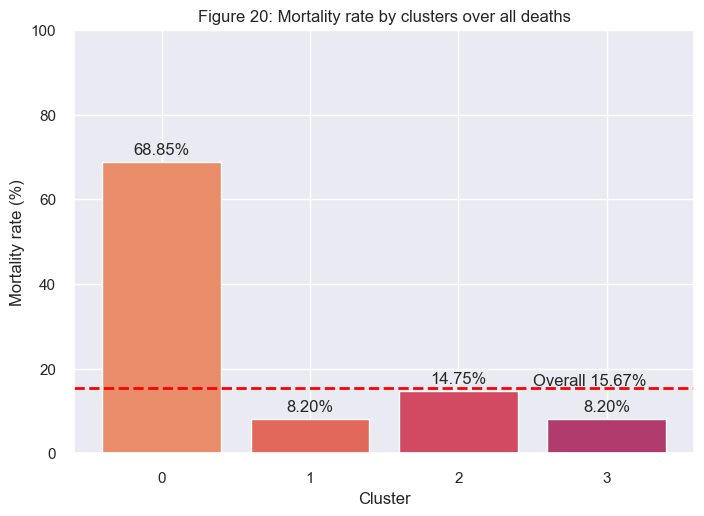

In [144]:
# Mortality rate in each cluster
mortality_cluster = []

for c in sorted(df_clean['cluster'].unique()):
    sub = df_clean[df_clean.cluster == c]
    mortality_cluster.append(100 * len(sub[sub.mortality == 'Dead']) / df_clean.mortality.value_counts()['Dead'])

plt.bar(["0","1","2","3"], mortality_cluster, color=palette)
plt.axhline(y=round(100* len(df_clean[df_clean.mortality == 'Dead']) / len(df_clean),2), color='red', linestyle='--', linewidth=2, label='Mortality rate')
plt.annotate('Overall 15.67%', xy=(0, 20), xytext=(2.5, 16))

for i, rate in enumerate(mortality_cluster):
    plt.text(i, rate + 1, f'{rate:.2f}%', ha='center', va='bottom')

plt.xlabel("Cluster")
plt.ylabel("Mortality rate (%)")
plt.title("Figure 20: Mortality rate by clusters over all deaths")
plt.ylim([0,100])

plt.show()

### On PCA

In [145]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_cleaned)

# Create a DataFrame for visualization
X_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
X_pca['cluster'] = df_clean['cluster']
X_pca

,PC1,PC2,PC3,cluster
0,0.279980,-1.998477,-1.180486,1
1,3.653448,-0.464053,0.350293,0
2,1.240309,-1.017045,-1.613759,1
3,-0.164842,-1.023233,0.524394,1
4,-0.953700,0.064909,-0.819146,2
...,...,...,...,...
389,0.888493,-0.668612,-1.207766,1
390,-1.389615,0.023529,2.599003,3
391,-1.292489,0.598989,-0.217630,2
392,-0.626498,-0.175729,0.086041,2


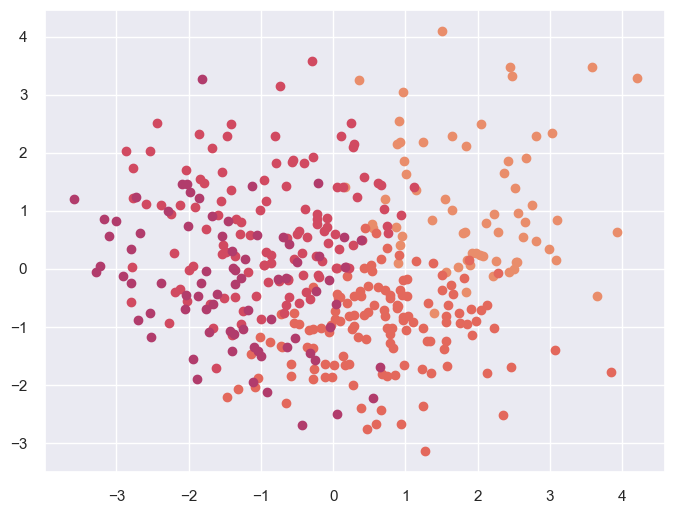

In [146]:
plt.figure(figsize=(8, 6))
for cluster in range(5):
    cluster_data = X_pca[X_pca['cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'cluster {cluster}', color=palette[cluster])

In [147]:
import plotly.express as px

fig = px.scatter_3d(X_pca, x='PC1', y='PC2', z='PC3',
              color='cluster', title="Figure 12:", color_discrete_sequence=palette)
fig.show()

# 6. Discussion

## 6.1. Property of the clusters

## 6.2. Relation to Outcomes

Female, 40, fat, fertile.